In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the training data
train_data = pd.read_excel('/content/Training.xlsx')

# Preprocess the data
def preprocess_data(data):
    # Normalize the capacity values
    scaler = MinMaxScaler()
    data['Capacity'] = scaler.fit_transform(data[['Capacity']])

    # Assign numeric IDs to Battery_ID
    data['Battery_ID'] = data.groupby('Battery_ID').ngroup()

    # Sort the data by Battery_ID and Cycle
    data = data.sort_values(['Battery_ID', 'Cycle'])

    return data, scaler

train_data, scaler = preprocess_data(train_data)


In [54]:
# Define the maximum sequence length
max_length = 495

# Reshape the data into sequences
def reshape_data(data, max_length):
    grouped = data.groupby('Battery_ID')
    sequences = []

    for _, group in grouped:
        seq = group[['Capacity']].values
        sequences.append(seq)

    return pad_sequences(sequences, maxlen=max_length, dtype='float32', padding='post', truncating='post')

X_train = reshape_data(train_data, max_length)
print(X_train.shape)

# Ensure X_train has the correct shape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))


(6, 495, 1)


In [55]:
from tensorflow.keras.layers import TimeDistributed

# Build the LSTM reconstruction model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    TimeDistributed(Dense(64, activation='relu')),
    Dropout(0.2),
    TimeDistributed(Dense(32, activation='relu')),
    Dropout(0.2),
    TimeDistributed(Dense(1))
])

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 495, 128)          66560     
                                                                 
 dropout_12 (Dropout)        (None, 495, 128)          0         
                                                                 
 time_distributed_12 (TimeD  (None, 495, 64)           8256      
 istributed)                                                     
                                                                 
 dropout_13 (Dropout)        (None, 495, 64)           0         
                                                                 
 time_distributed_13 (TimeD  (None, 495, 32)           2080      
 istributed)                                                     
                                                                 
 dropout_14 (Dropout)        (None, 495, 32)          

In [56]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.3860 - val_loss: 0.4073
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 290ms/step - loss: 0.3495 - val_loss: 0.3644
Epoch 3/50
1/1 [==============================] - 0s 337ms/step - loss: 0.3132 - val_loss: 0.3223
Epoch 4/50
1/1 [==============================] - 0s 291ms/step - loss: 0.2800 - val_loss: 0.2809
Epoch 5/50
1/1 [==============================] - 0s 281ms/step - loss: 0.2451 - val_loss: 0.2415
Epoch 6/50
1/1 [==============================] - 0s 312ms/step - loss: 0.2124 - val_loss: 0.2027
Epoch 7/50
1/1 [==============================] - 0s 294ms/step - loss: 0.1791 - val_loss: 0.1633
Epoch 8/50
1/1 [==============================] - 0s 277ms/step - loss: 0.1418 - val_loss: 0.1229
Epoch 9/50
1/1 [==============================] - 0s 291ms/step - loss: 0.1111 - val_loss: 0.0824
Epoch 10/50
1/1 [==============================] - 0s 312ms/step - loss: 0.0788 - val_loss: 0.0454
Epoch 11/50
1/1 [==============================] - 0s 285ms/step - loss: 0.0522 - val_loss: 0.0179
Epoch 12/50
1/1 [============

In [75]:
recons = model.predict(X_train)
recons_inverse = scaler.inverse_transform(recons.reshape(-1, 1)).reshape(recons.shape)
X_train_inverse = scaler.inverse_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)

recons_errors = np.abs((X_train_inverse - recons_inverse))

# Set a threshold for anomaly detection
threshold = np.percentile(recons_errors, 35)
print(threshold)

1/1 [==============================] - 0s 103ms/step
0.013470607995986936


In [76]:
# Load the testing data
test_data = pd.read_excel('/content/TestingData.xlsx')

# Preprocess the data
def preprocess_data(data):
    # Normalize the capacity values
    scaler = MinMaxScaler()
    data['Capacity'] = scaler.fit_transform(data[['Capacity']])

    # Assign numeric IDs to Battery_ID
    data['Battery_ID'] = data.groupby('Battery_ID').ngroup()

    # Sort the data by Battery_ID and Cycle
    data = data.sort_values(['Battery_ID', 'Cycle'])

    return data, scaler

test_data, scaler = preprocess_data(test_data)


# Define the maximum sequence length
max_length = 495

# Reshape the data into sequences
def reshape_data(data, max_length):
    grouped = data.groupby('Battery_ID')
    sequences = []

    for _, group in grouped:
        seq = group[['Capacity']].values
        sequences.append(seq)

    return pad_sequences(sequences, maxlen=max_length, dtype='float32', padding='post', truncating='post')

X_test = reshape_data(test_data, max_length)
print(X_test.shape)

# Ensure X_train has the correct shape
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


(6, 495, 1)


1/1 [==============================] - 0s 262ms/step
2180


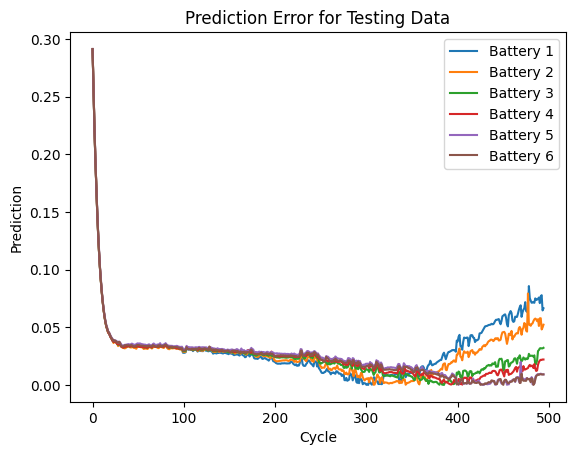

In [82]:
import matplotlib.pyplot as plt
# Load the pre-trained model
model = load_model('best_model.h5')

# Make predictions
reconstructions = model.predict(X_test)

# Inverse transform the predictions and the original data
reconstructions_inverse = scaler.inverse_transform(reconstructions.reshape(-1, 1)).reshape(reconstructions.shape)
X_test_inverse = scaler.inverse_transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Calculate reconstruction error for each cycle
reconstruction_errors = np.abs((X_test_inverse - reconstructions_inverse))

# Set a threshold for anomaly detection
n_anomalies = np.sum(reconstruction_errors > threshold)
print(n_anomalies)

# Plot the reconstruction error for each battery
for i in range(reconstruction_errors.shape[0]):
    plt.plot(reconstruction_errors[i], label=f'Battery {i+1}')


plt.title('Prediction Error for Testing Data')
plt.xlabel('Cycle')
plt.ylabel('Prediction')
plt.legend()
plt.show()


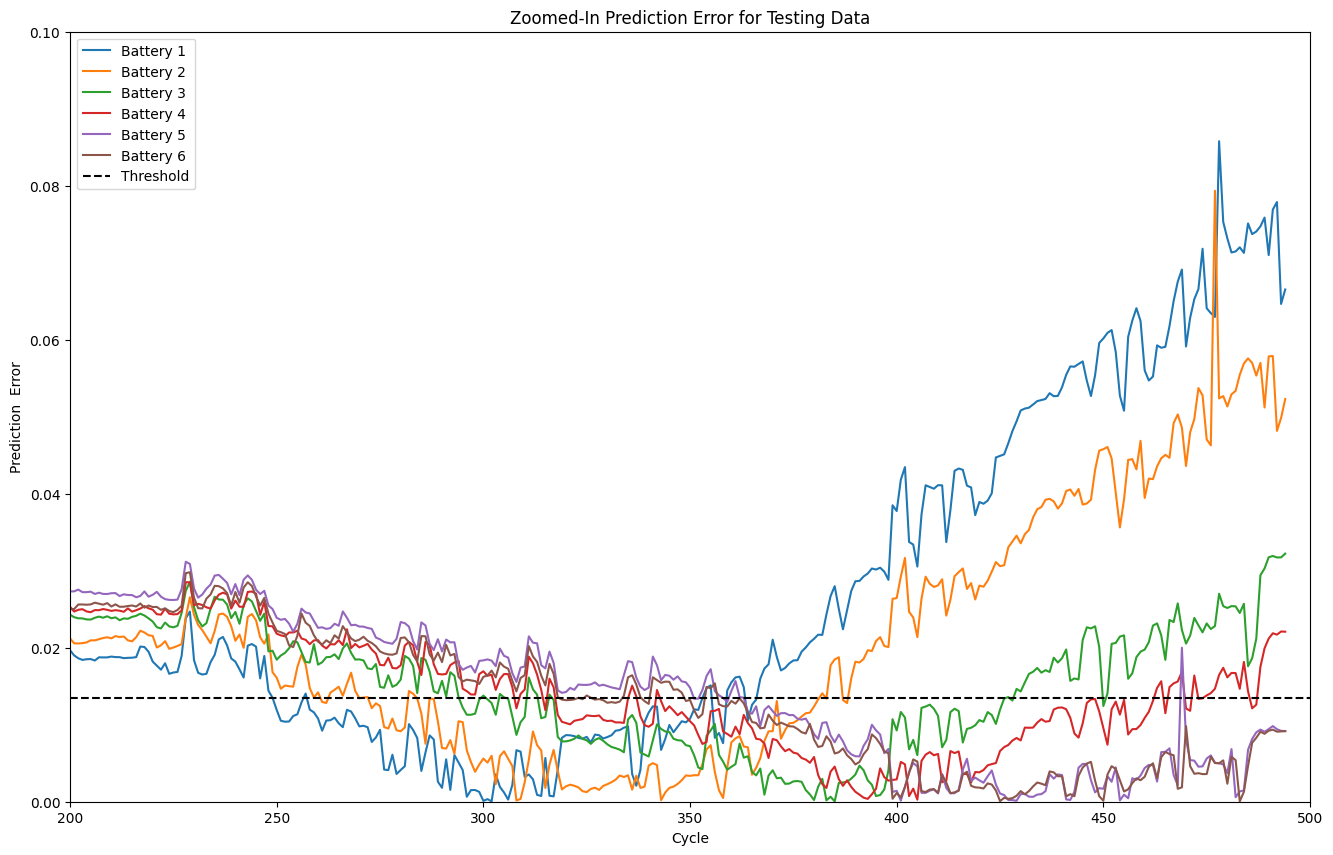

In [83]:
 #Zoomed-in plot
zoom_cycle_start = 200  # Start cycle for zoomed-in plot
zoom_cycle_end = 500   # End cycle for zoomed-in plot
zoom_y_min = 0  # Minimum y-axis value for zoomed-in plot
zoom_y_max = 0.1  # Maximum y-axis value for zoomed-in plot (adjust as needed)

# Plot the reconstruction error for each battery (zoomed-in)
plt.figure(figsize=(16, 10))
for i in range(reconstruction_errors.shape[0]):
    plt.plot(reconstruction_errors[i], label=f'Battery {i+1}')

plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold')
plt.title('Zoomed-In Prediction Error for Testing Data')
plt.xlabel('Cycle')
plt.ylabel('Prediction  Error')
plt.legend()
plt.xlim(zoom_cycle_start, zoom_cycle_end)
plt.ylim(zoom_y_min, zoom_y_max)
plt.show()

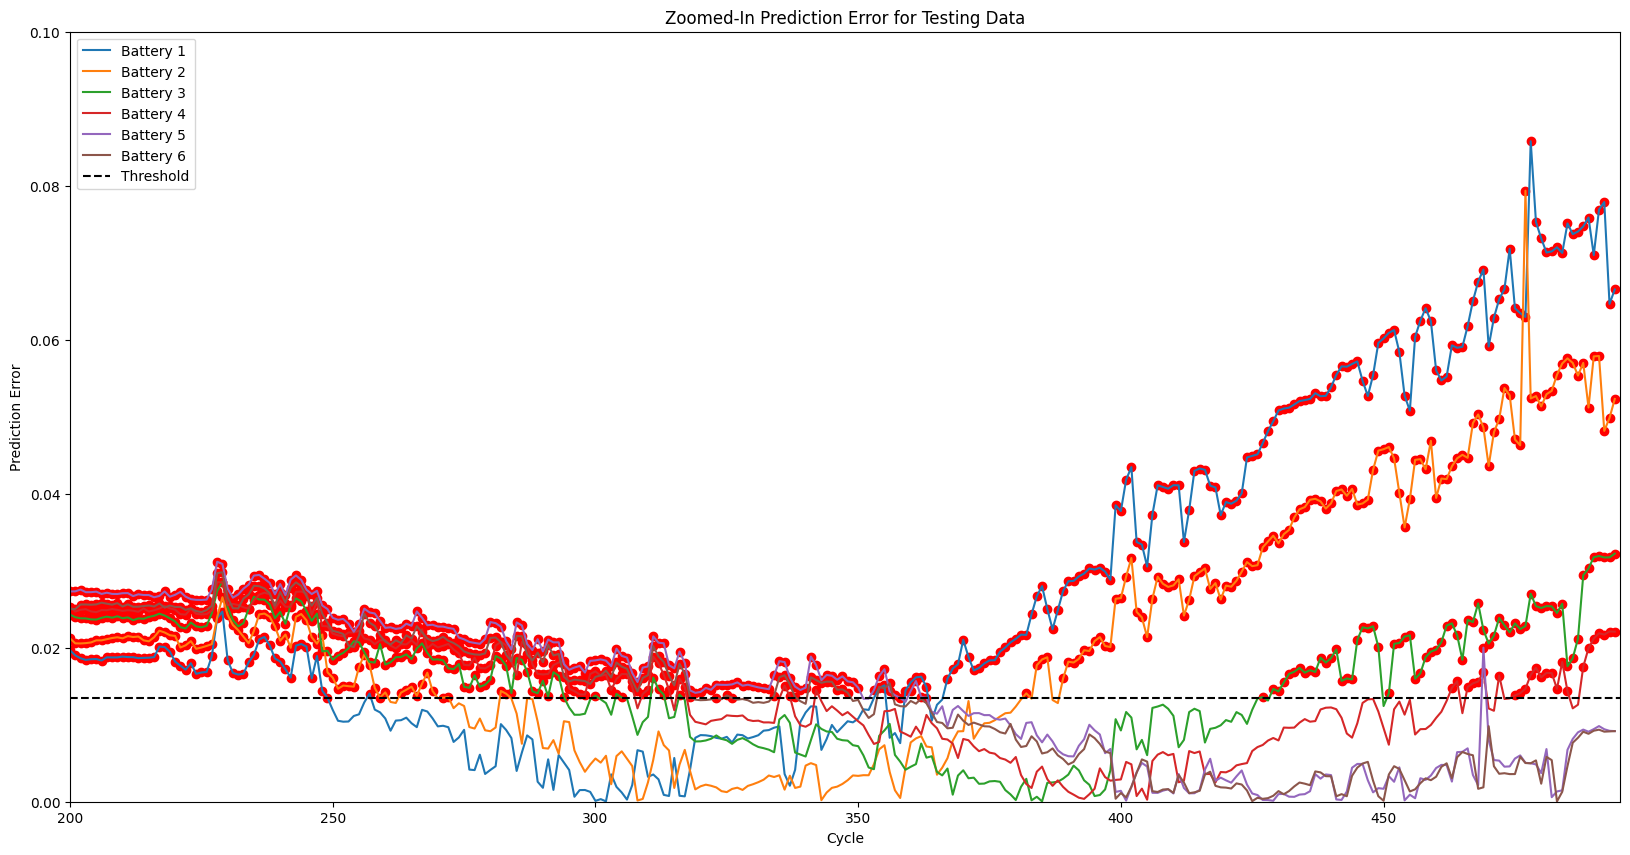

In [84]:
# Zoomed-in plot
zoom_cycle_start = 200  # Start cycle for zoomed-in plot
zoom_cycle_end = 500    # End cycle for zoomed-in plot
zoom_y_min = 0          # Minimum y-axis value for zoomed-in plot
zoom_y_max = 0.1        # Maximum y-axis value for zoomed-in plot (adjust as needed)

# Plot the reconstruction error for each battery (zoomed-in)
plt.figure(figsize=(20, 10))
for i in range(reconstruction_errors.shape[0]):
    plt.plot(reconstruction_errors[i], label=f'Battery {i+1}')

    # Annotate anomalies with markers
    for j in range(zoom_cycle_start, min(zoom_cycle_end, reconstruction_errors.shape[1])):
        if reconstruction_errors[i, j] > threshold:
            plt.scatter(j, reconstruction_errors[i, j], color='red', marker='o')  # Use red marker for anomalies

plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold')
plt.title('Zoomed-In Prediction Error for Testing Data')
plt.xlabel('Cycle')
plt.ylabel('Prediction Error')
plt.legend()
plt.xlim(zoom_cycle_start, min(zoom_cycle_end, reconstruction_errors.shape[1]))
plt.ylim(zoom_y_min, zoom_y_max)
plt.show()

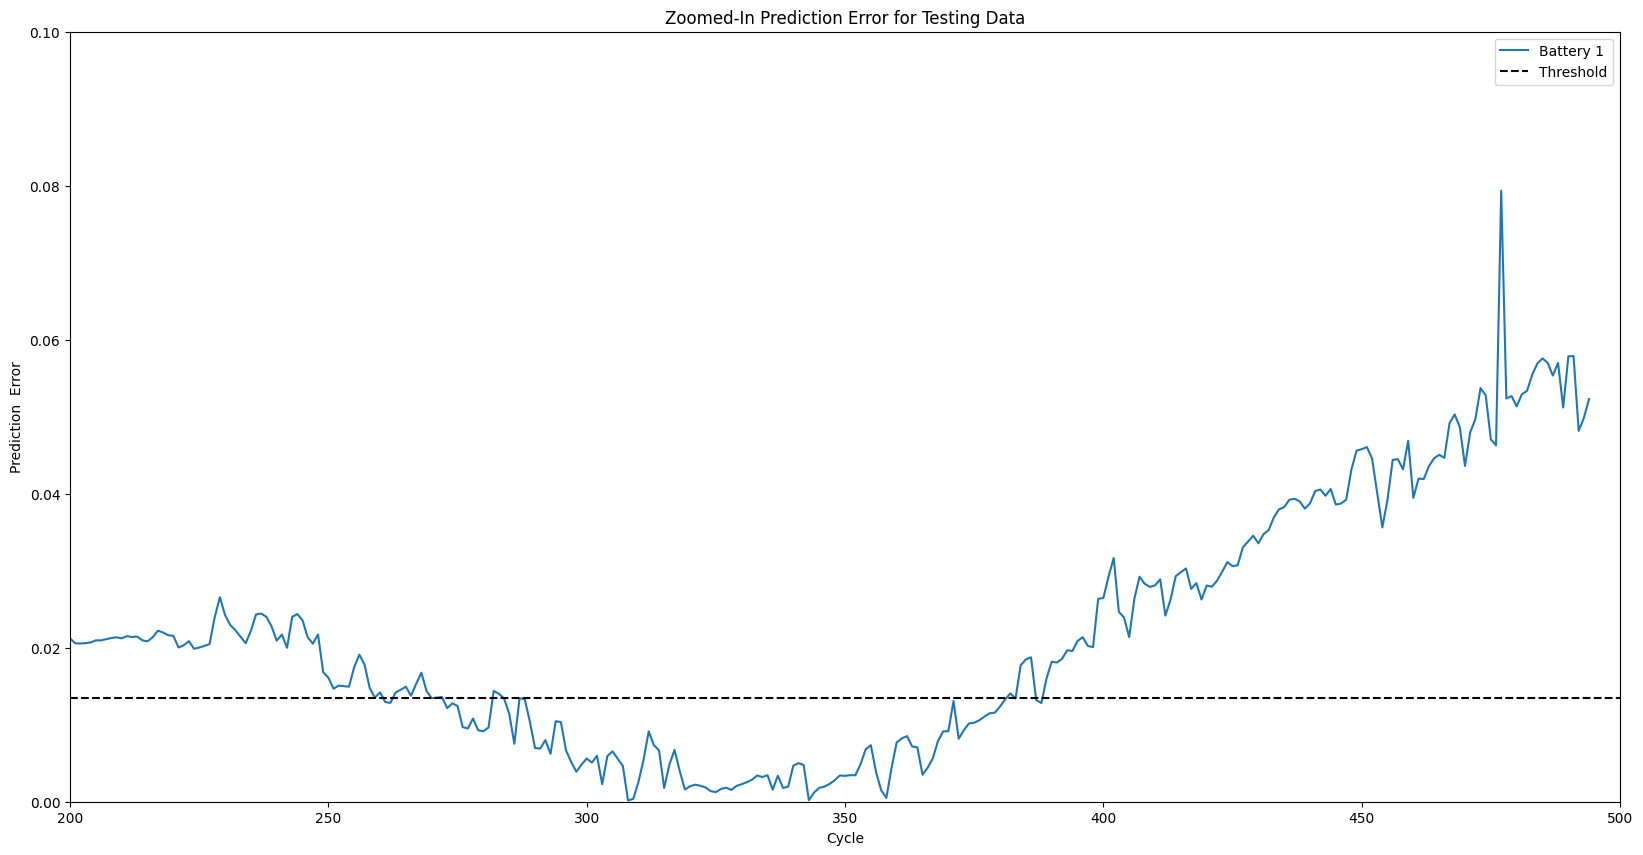

In [86]:
import matplotlib.pyplot as plt
# Plot the reconstruction error for each battery (zoomed-in)
plt.figure(figsize=(20, 10))


plt.plot(reconstruction_errors[1], label=f'Battery {1}')

plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold')
plt.title('Zoomed-In Prediction Error for Testing Data')
plt.xlabel('Cycle')
plt.ylabel('Prediction  Error')
plt.legend()
plt.xlim(zoom_cycle_start, zoom_cycle_end)
plt.ylim(zoom_y_min, zoom_y_max)
plt.show()

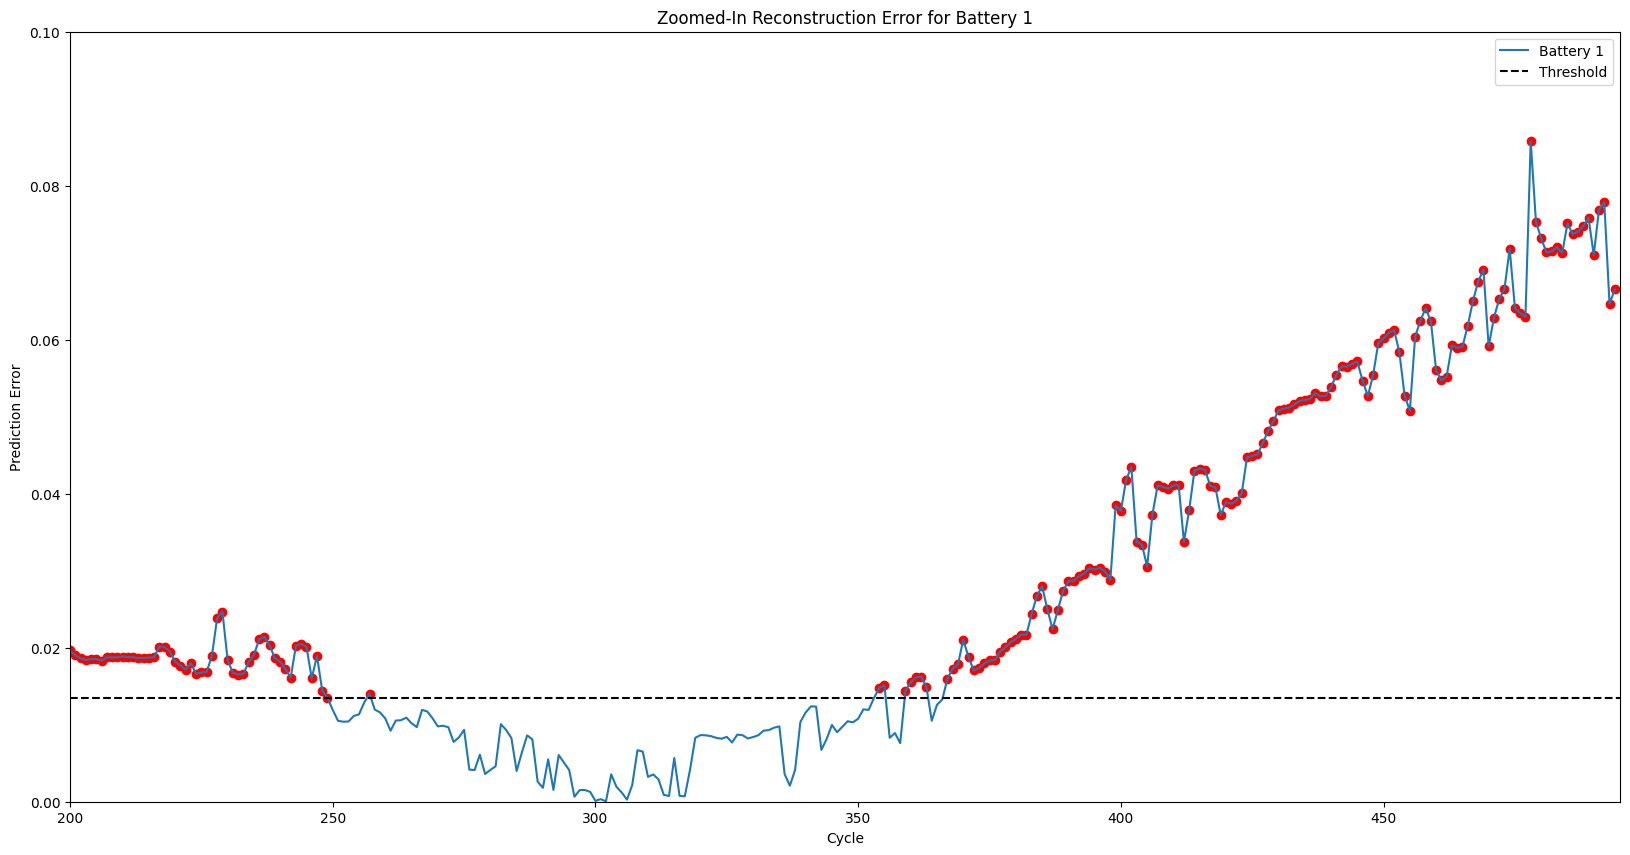

In [87]:

# Zoomed-in plot for a single battery (battery index 0)
battery_index = 0  # Change this index to plot a different battery

zoom_cycle_start = 200  # Start cycle for zoomed-in plot
zoom_cycle_end = 500    # End cycle for zoomed-in plot
zoom_y_min = 0          # Minimum y-axis value for zoomed-in plot
zoom_y_max = 0.1        # Maximum y-axis value for zoomed-in plot (adjust as needed)

# Plot the reconstruction error for the specified battery (zoomed-in)
plt.figure(figsize=(20, 10))
plt.plot(reconstruction_errors[battery_index], label=f'Battery {battery_index + 1}')

# Annotate anomalies with markers
for j in range(zoom_cycle_start, min(zoom_cycle_end, reconstruction_errors.shape[1])):
    if reconstruction_errors[battery_index, j] > threshold:
        plt.scatter(j, reconstruction_errors[battery_index, j], color='red', marker='o')  # Use red marker for anomalies

plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold')
plt.title(f'Zoomed-In Reconstruction Error for Battery {battery_index + 1}')
plt.xlabel('Cycle')
plt.ylabel('Prediction Error')
plt.legend()
plt.xlim(zoom_cycle_start, min(zoom_cycle_end, reconstruction_errors.shape[1]))
plt.ylim(zoom_y_min, zoom_y_max)
plt.show()